### Gradient Boosting implementaion from scratch

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor  
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [2]:
df = pd.read_csv('../../src/cleaned_data/cleaned_data.csv')

Helper Functions

In [3]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

Log-Loss Gradient (Residuals)
For binary classification, the gradient (residual) is y_true - y_pred_prob.

In [4]:
def compute_residuals(y_true, y_pred_log_odds):
    y_pred_prob = sigmoid(y_pred_log_odds)
    return y_true - y_pred_prob

Gradient Boosting Class


In [5]:
class SimpleGradientBoostingClassifier:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []  # Stores regression trees
        self.initial_log_odds = None  # Initial prediction (log-odds)

    def fit(self, X, y):
        # Step 1: Initial prediction (log-odds of class 1)
        self.initial_log_odds = np.log(np.mean(y) / (1 - np.mean(y))) if np.mean(y) != 0 else 0
        y_pred_log_odds = np.full_like(y, self.initial_log_odds, dtype=float)

        for _ in range(self.n_estimators):
            # Step 2: Compute residuals (gradients of log loss)
            residuals = compute_residuals(y, y_pred_log_odds)

            # Step 3: Train a regression tree to predict residuals
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, residuals)

            # Step 4: Update predictions with the tree's output
            y_pred_log_odds += self.learning_rate * tree.predict(X)

            # Save the tree
            self.trees.append(tree)

    def predict_proba(self, X):
        # Start with initial log-odds
        y_pred_log_odds = np.full(X.shape[0], self.initial_log_odds, dtype=float)

        # Add contributions from all trees
        for tree in self.trees:
            y_pred_log_odds += self.learning_rate * tree.predict(X)

        # Convert log-odds to probabilities
        return sigmoid(y_pred_log_odds)

    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)

Train the model

In [6]:
# Load your data
X = df.drop('Label', axis=1).values
y = df['Label'].values

# Split into train-test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [7]:
# Initialize and train the model
gb = SimpleGradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3
)
gb.fit(X_train, y_train)


In [8]:
# Predict
y_pred = gb.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy*100:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(report)

Accuracy: 99.1176

Confusion Matrix:
[[885  15]
 [  0 800]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       900
           1       0.98      1.00      0.99       800

    accuracy                           0.99      1700
   macro avg       0.99      0.99      0.99      1700
weighted avg       0.99      0.99      0.99      1700



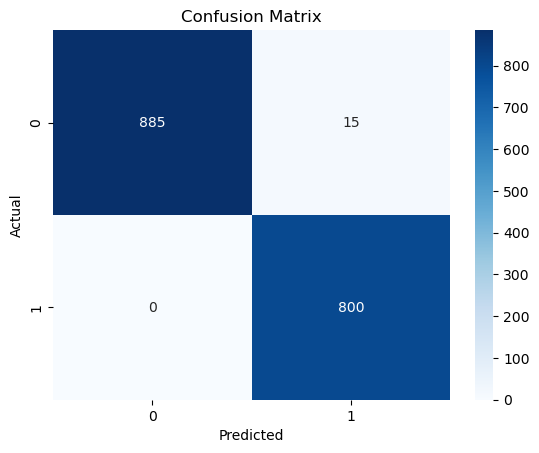

In [9]:
# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()